In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [22]:
# Data
games_season = pd.read_csv('games_season.csv')
games_tourney = pd.read_csv('games_tourney.csv')

print('Regular season data')
print(games_season.head())

print('Tournament data')
print(games_tourney.head())

# Count the number of unique teams
team_ids = np.unique(games_season['team_1'])
n_teams = team_ids.shape[0]

Regular season data
   season  team_1  team_2  home  score_diff  score_1  score_2  won
0    1985    3745    6664     0          17       81       64    1
1    1985     126    7493     1           7       77       70    1
2    1985     288    3593     1           7       63       56    1
3    1985    1846    9881     1          16       70       54    1
4    1985    2675   10298     1          12       86       74    1
Tournament data
   season  team_1  team_2  home  seed_diff  score_diff  score_1  score_2  won
0    1985     288      73     0         -3          -9       41       50    0
1    1985    5929      73     0          4           6       61       55    1
2    1985    9884      73     0          5          -4       59       63    0
3    1985      73     288     0          3           9       50       41    1
4    1985    3920     410     0          1          -9       54       63    0


In [3]:
# Team Strength Model
from tensorflow.keras.layers import Input, Embedding, Flatten
from tensorflow.keras.models import Model

# Create an input layer for the team ID
teamid_in = Input(shape=(1,))

# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams, output_dim=1, input_length=1, name='Team-Strength')

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

2021-11-28 15:57:33.353339: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-28 15:57:33.353386: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-28 15:57:34.792086: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-28 15:57:34.792166: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-28 15:57:34.792184: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-FC4EGDV): /proc/driver/nvidia/version does not exist
2021-11-28 15:57:34.792382: I tensorflow/core/platform/cpu_fe

In [4]:
# Shared layers

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Subtract

# Input layers for team 1 and 2
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Lookup team 1 and 2 in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Create a subtract layer to merge team strengths
score_diff = Subtract()([team_1_strength, team_2_strength])

# Create the model
model = Model([team_in_1, team_in_2], score_diff)
model.compile(optimizer='adam', loss='mean_absolute_error')

In [5]:
# Get the team_1 column from the regular season data
input_1 = games_season['team_1']

# Get the team_2 column from the regular season data
input_2 = games_season['team_2']

# Get the score_diff column from the regular season data
target = games_season['score_diff']

# Fit the model
history = model.fit([input_1, input_2], target, epochs=2**9, batch_size=2**11, validation_split=.1, verbose=0)

2021-11-28 15:57:34.948760: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


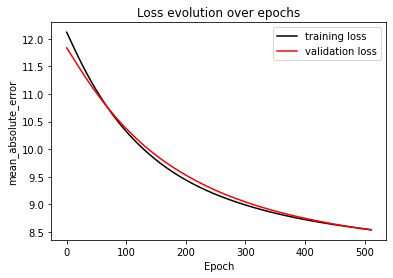

In [6]:
plt.plot(history.history['loss'], label='training loss', color='black')
plt.plot(history.history['val_loss'], label='validation loss', color='red')
plt.title('Loss evolution over epochs')
plt.xlabel('Epoch')
plt.ylabel('mean_absolute_error')
plt.legend()
plt.show()

In [7]:
# Get team_1 from the tournament data
input_1 = games_tourney['team_1']

# Get team_2 from the tournament data
input_2 = games_tourney['team_2']

# Get score_diff from the tournament data
target = games_tourney['score_diff']

# Evaluate the model using these inputs
model.evaluate([input_1, input_2], target)

133/133 [==============================] - 0s 862us/step - loss: 9.1152


9.115209579467773

In [63]:
team_1 = games_season[['team_1', 'score_1']]

ranking_by_mean = list(team_1.groupby('team_1').mean().sort_values(by='score_1', ascending=False).index.values)

df = pd.DataFrame(
  {'strength_predictions': team_strength_model.predict(team_ids).flatten()},
  index=pd.Index(data=team_ids, name='team_id')
)

ranking_by_strength = list(df.sort_values(by='strength_predictions', ascending=False).index.values)

rankings_df = pd.DataFrame({
  'team_id': team_ids,
  'mean_score_ranking': [ranking_by_mean.index(team_id) for team_id in team_ids],
  'strength_ranking': [ranking_by_strength.index(team_id) for team_id in team_ids]
})

rankings_df['ranking_difference'] = np.abs(rankings_df.mean_score_ranking - rankings_df.strength_ranking)

rankings_df

,team_id,mean_score_ranking,strength_ranking,ranking_difference
0,0,9583,10609,1026
1,1,10215,10255,40
2,2,5788,9024,3236
3,3,7144,9127,1983
4,4,5235,6409,1174
...,...,...,...,...
10883,10883,2764,6994,4230
10884,10884,5125,9472,4347
10885,10885,2300,9598,7298
10886,10886,2142,8255,6113


In [65]:
# Ranking by mean_score is very different from ranking by strength
rankings_df.ranking_difference.mean()

2412.0222263041883

In [67]:
games_season.won

0         1
1         1
2         1
3         1
4         1
         ..
312173    0
312174    0
312175    0
312176    0
312177    0
Name: won, Length: 312178, dtype: int64